# Задача 8. Сравнение методов классификации

** **Дедлайн**: 28.11.2025, 23:59
* Полный балл: 15

## Задача

- [+] Найти данные, на которых интересно будет решать задачу классификации (больше `1000` строк, больше `5` признаков).
- [+] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [+] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [+] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [+] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания для библиотечных реализаций (например, из **sklearn**) четырёх методов классификации.

##### Часть 1 (Поиски Данных и выполнение полезных преобразований)

### Описание датасета
Датасет представляет данные банковского маркетинга для прогнозирования подписки на депозит
#### Описание столбцов датасета
- age - возраст клиента
- job - сфера занятости
- marital - семейное положение
-education - уровень образования
- default - наличие дефолта по кредиту
- balance - средний годовой баланс на счете
- housing - наличие ипотечного кредита
- loan - наличие персонального кредита
- contact - тип связи с клиентом
- day - день последнего контакта
- month - месяц последнего контакта
- duration - длительность последнего контакта (в секундах)
- campaign - количество контактов во время текущей кампании
- pdays - количество дней с последнего контакта в предыдущей кампании (-1 - не контактировали ранее)
- previous - количество контактов до текущей кампании
- poutcome - результат предыдущей маркетинговой кампании
- y - подписался ли клиент на депозит в этой кампании

In [70]:
import pandas as pd

df = pd.read_csv('bank.csv')

print(f"Размер: {df.shape}")
print(df[:5])

Размер: (4521, 17)
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  


#### Выполняем чистку (убираем дубликаты и пропущенные значения)

In [71]:
duplicates = df.duplicated().sum()
print(f"Найдено дубликатов: {duplicates}")

Найдено дубликатов: 0


Дубликатов не найдено. Осталось только провести проверку для пропусков

In [72]:
missing_data = df.isnull().sum()
print(f"Найдено пропусков: \n{missing_data}")

Найдено пропусков: 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Видим, что пропусков не найдено. Видимо хороший датасет нашли.

### Теперь категоризуем необходимые данные:
- Для категоризации буду использовать LabelEncoder, так как он подходит как для бинарных, так и для многоклассовых. Сделаем все, кроме месяца он будет отдельно, так как там должна быть специальная трансформация. Использовал для категоризации данных Label

In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df['month'] = df['month'].map(month_mapping)

categorical_columns = ['job', 'marital', 'education', 'default', 'housing',
                      'loan', 'contact', 'poutcome', 'y']

for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
print(df.shape)
print(df[:5])

(4521, 17)
   age  job  marital  education  default  balance  housing  loan  contact  \
0   30   10        1          0        0     1787        0     0        0   
1   33    7        1          1        0     4789        1     1        0   
2   35    4        2          2        0     1350        1     0        0   
3   30    4        1          2        0     1476        1     1        2   
4   59    1        1          1        0        0        1     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  y  
0   19     10        79         1     -1         0         3  0  
1   11      5       220         1    339         4         0  0  
2   16      4       185         1    330         1         0  0  
3    3      6       199         4     -1         0         3  0  
4    5      5       226         1     -1         0         3  0  


### Проведем разведочный анализ, используем визуализацию, сделаем выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

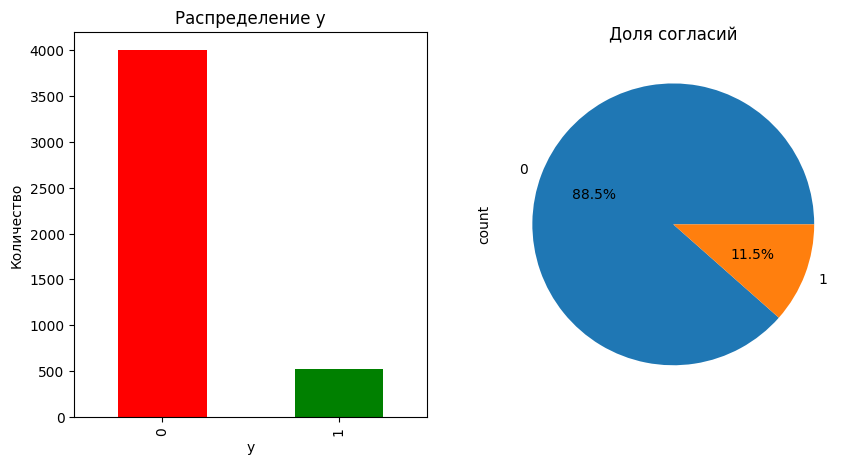

In [74]:
import matplotlib.pyplot as plt

# A graph that shows how many people have signed up for a deposit and how many have not
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['y'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Распределение y')
plt.ylabel('Количество')

# Percentage ratio for or against
plt.subplot(1, 2, 2)
df['y'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Доля согласий')
plt.show()

### Теперь выведем графики распределения

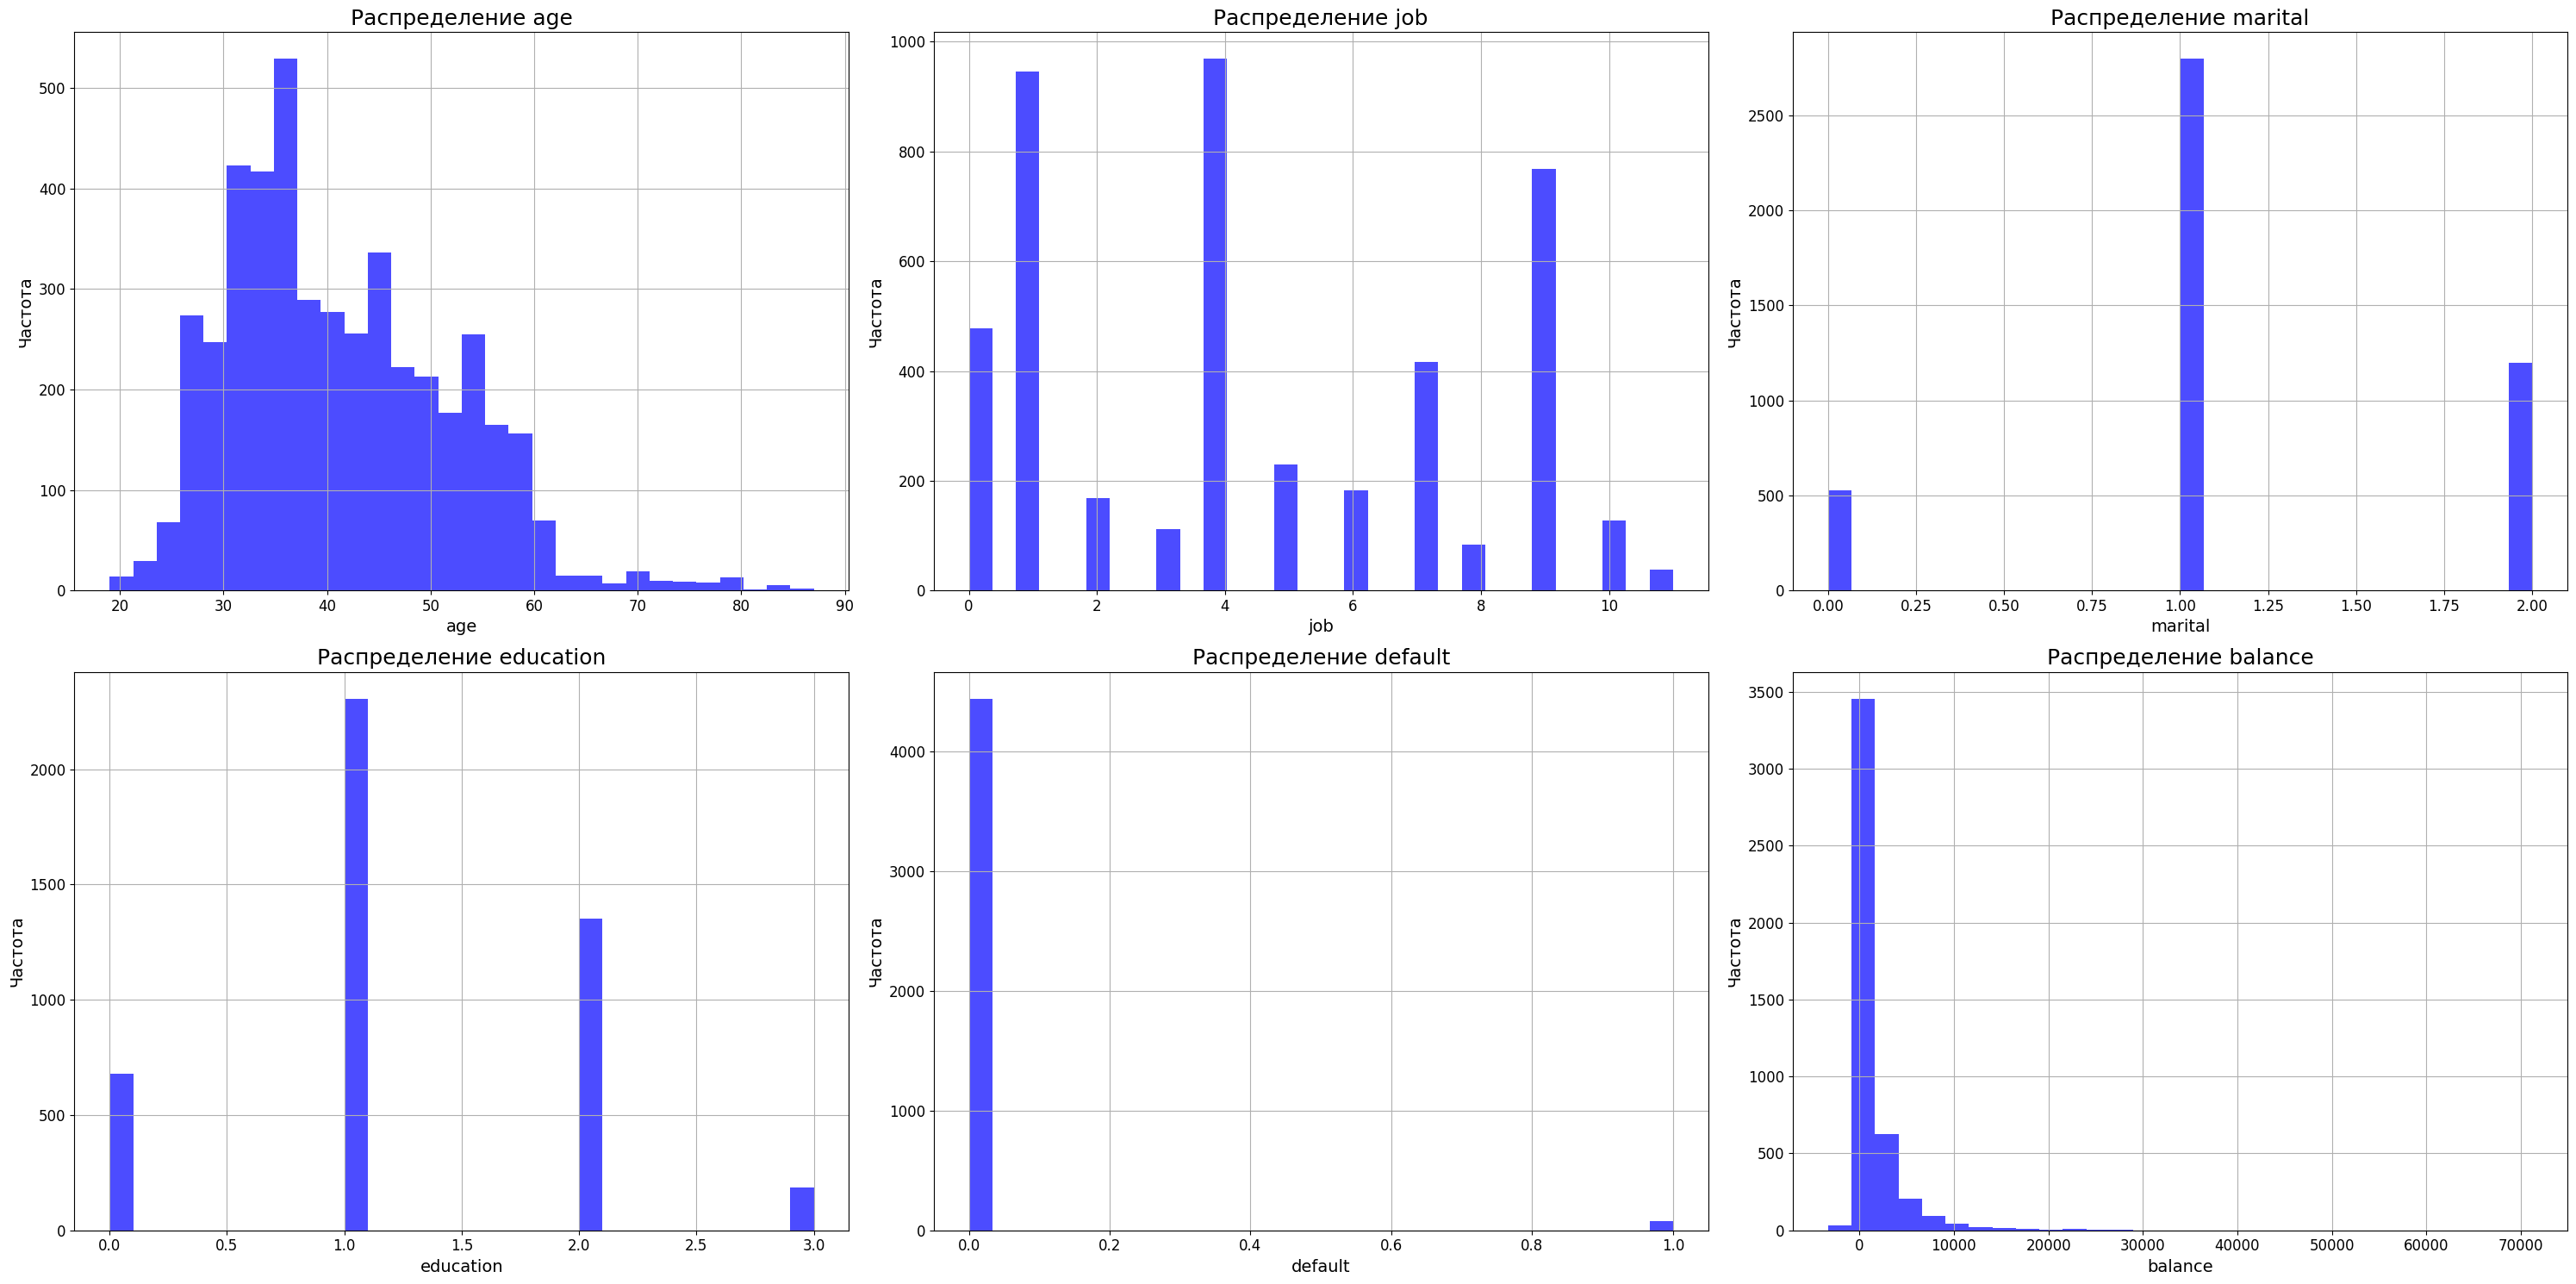

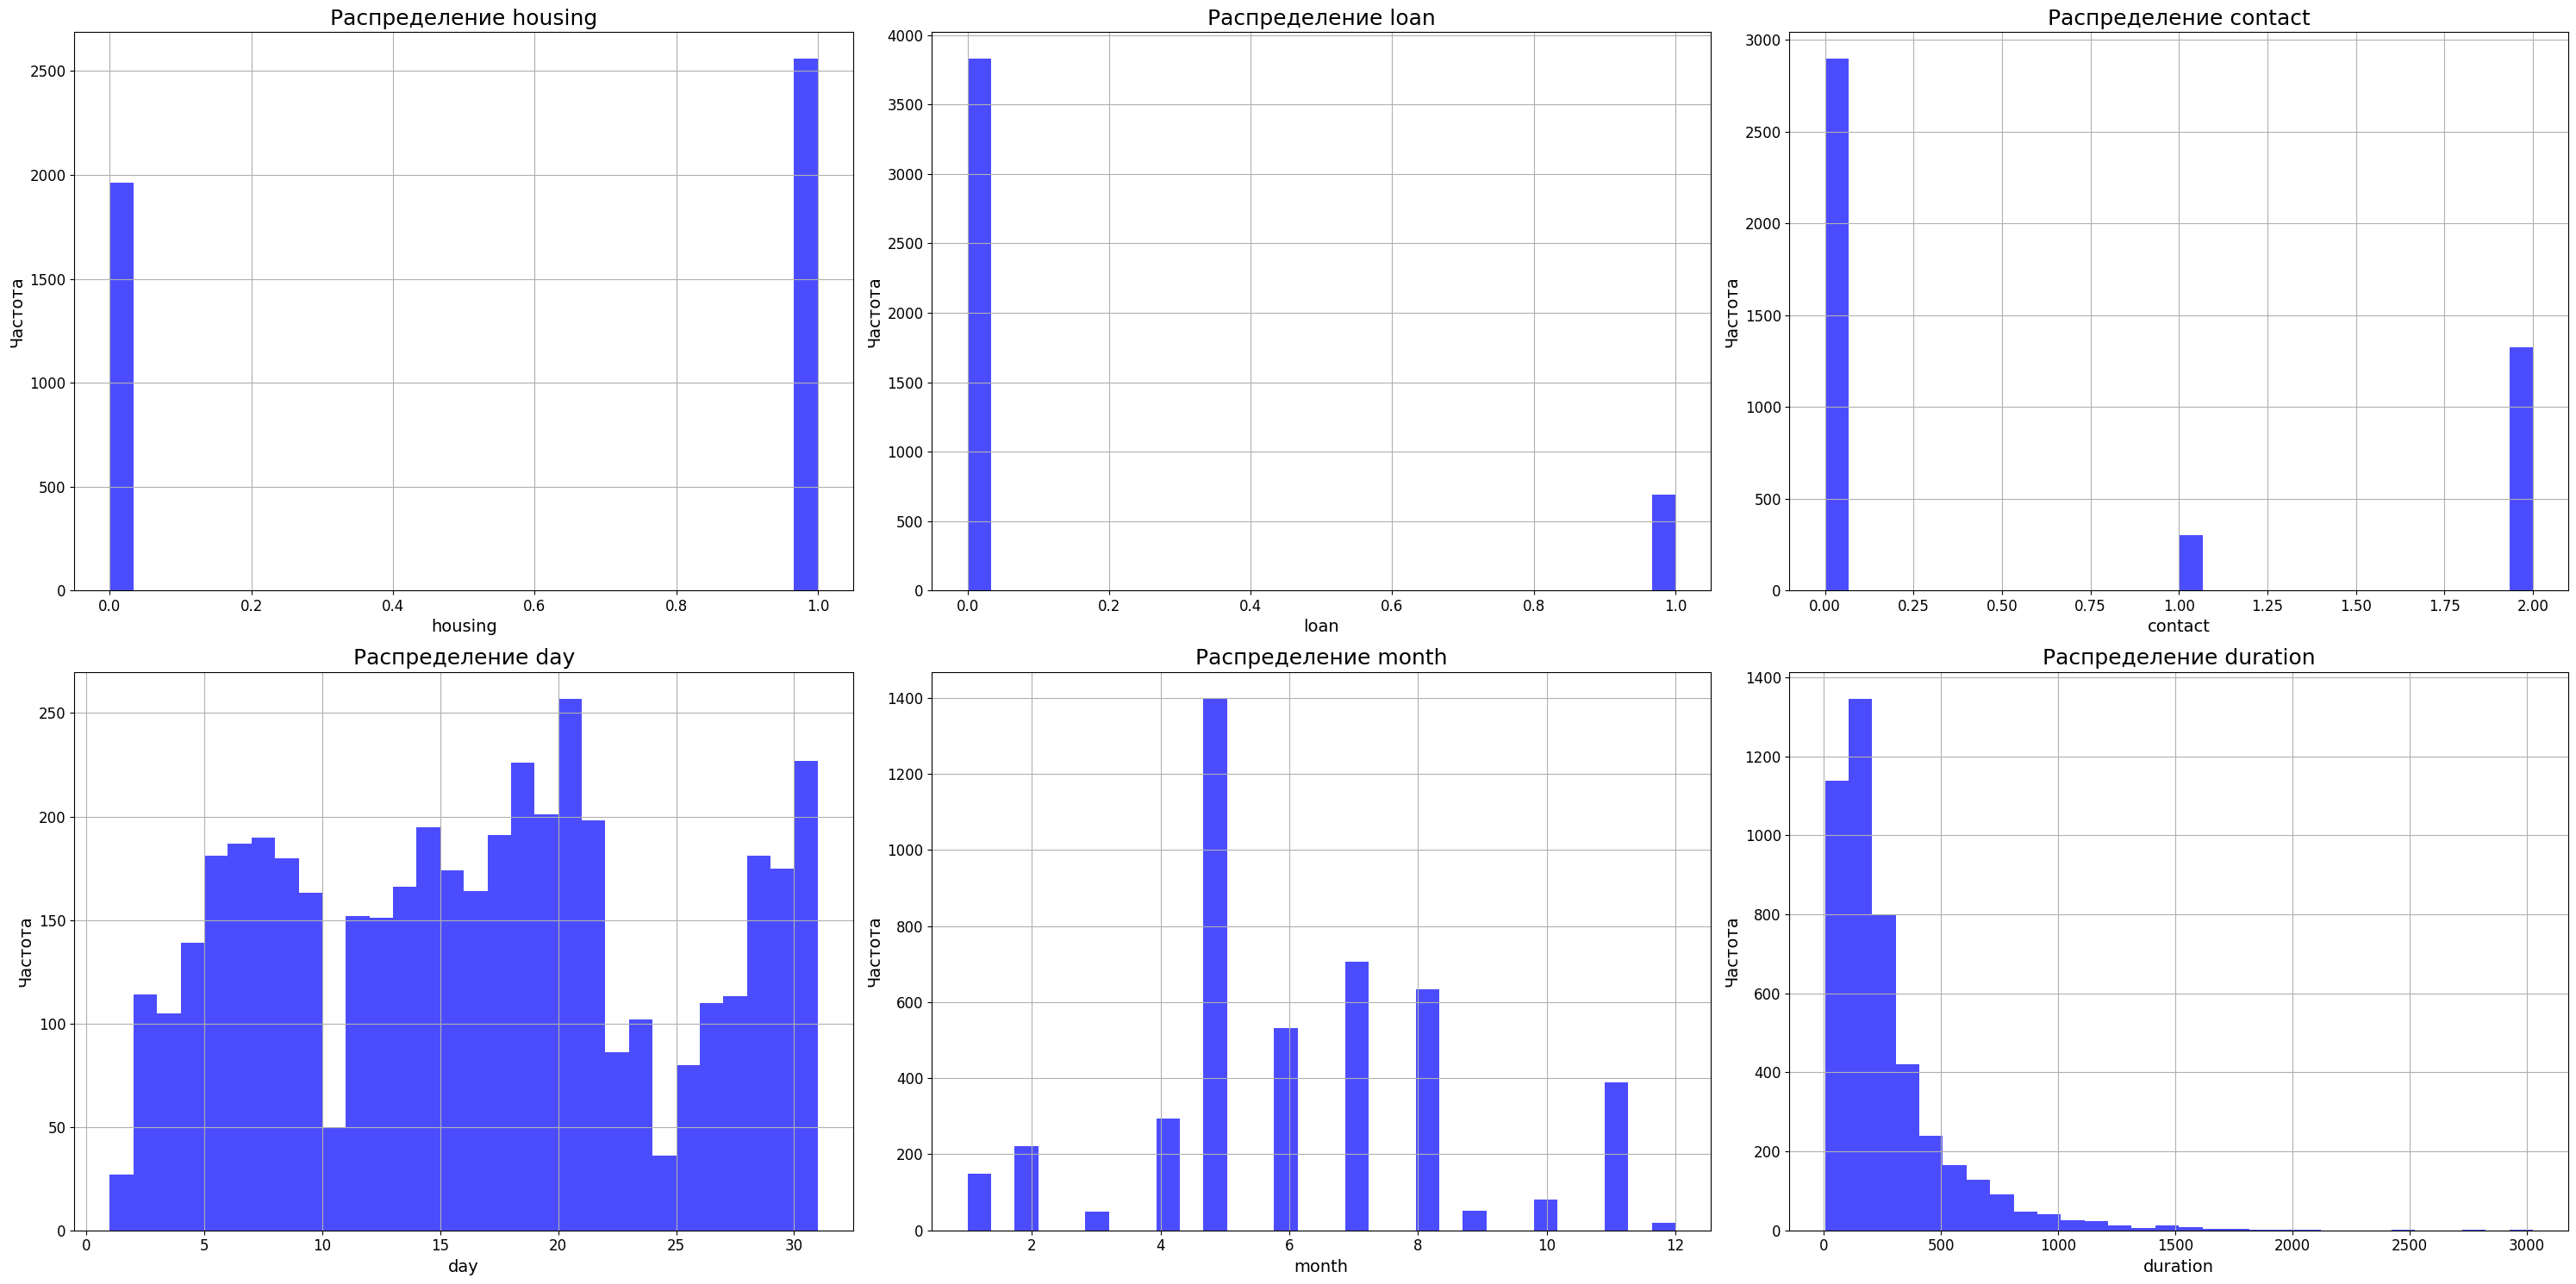

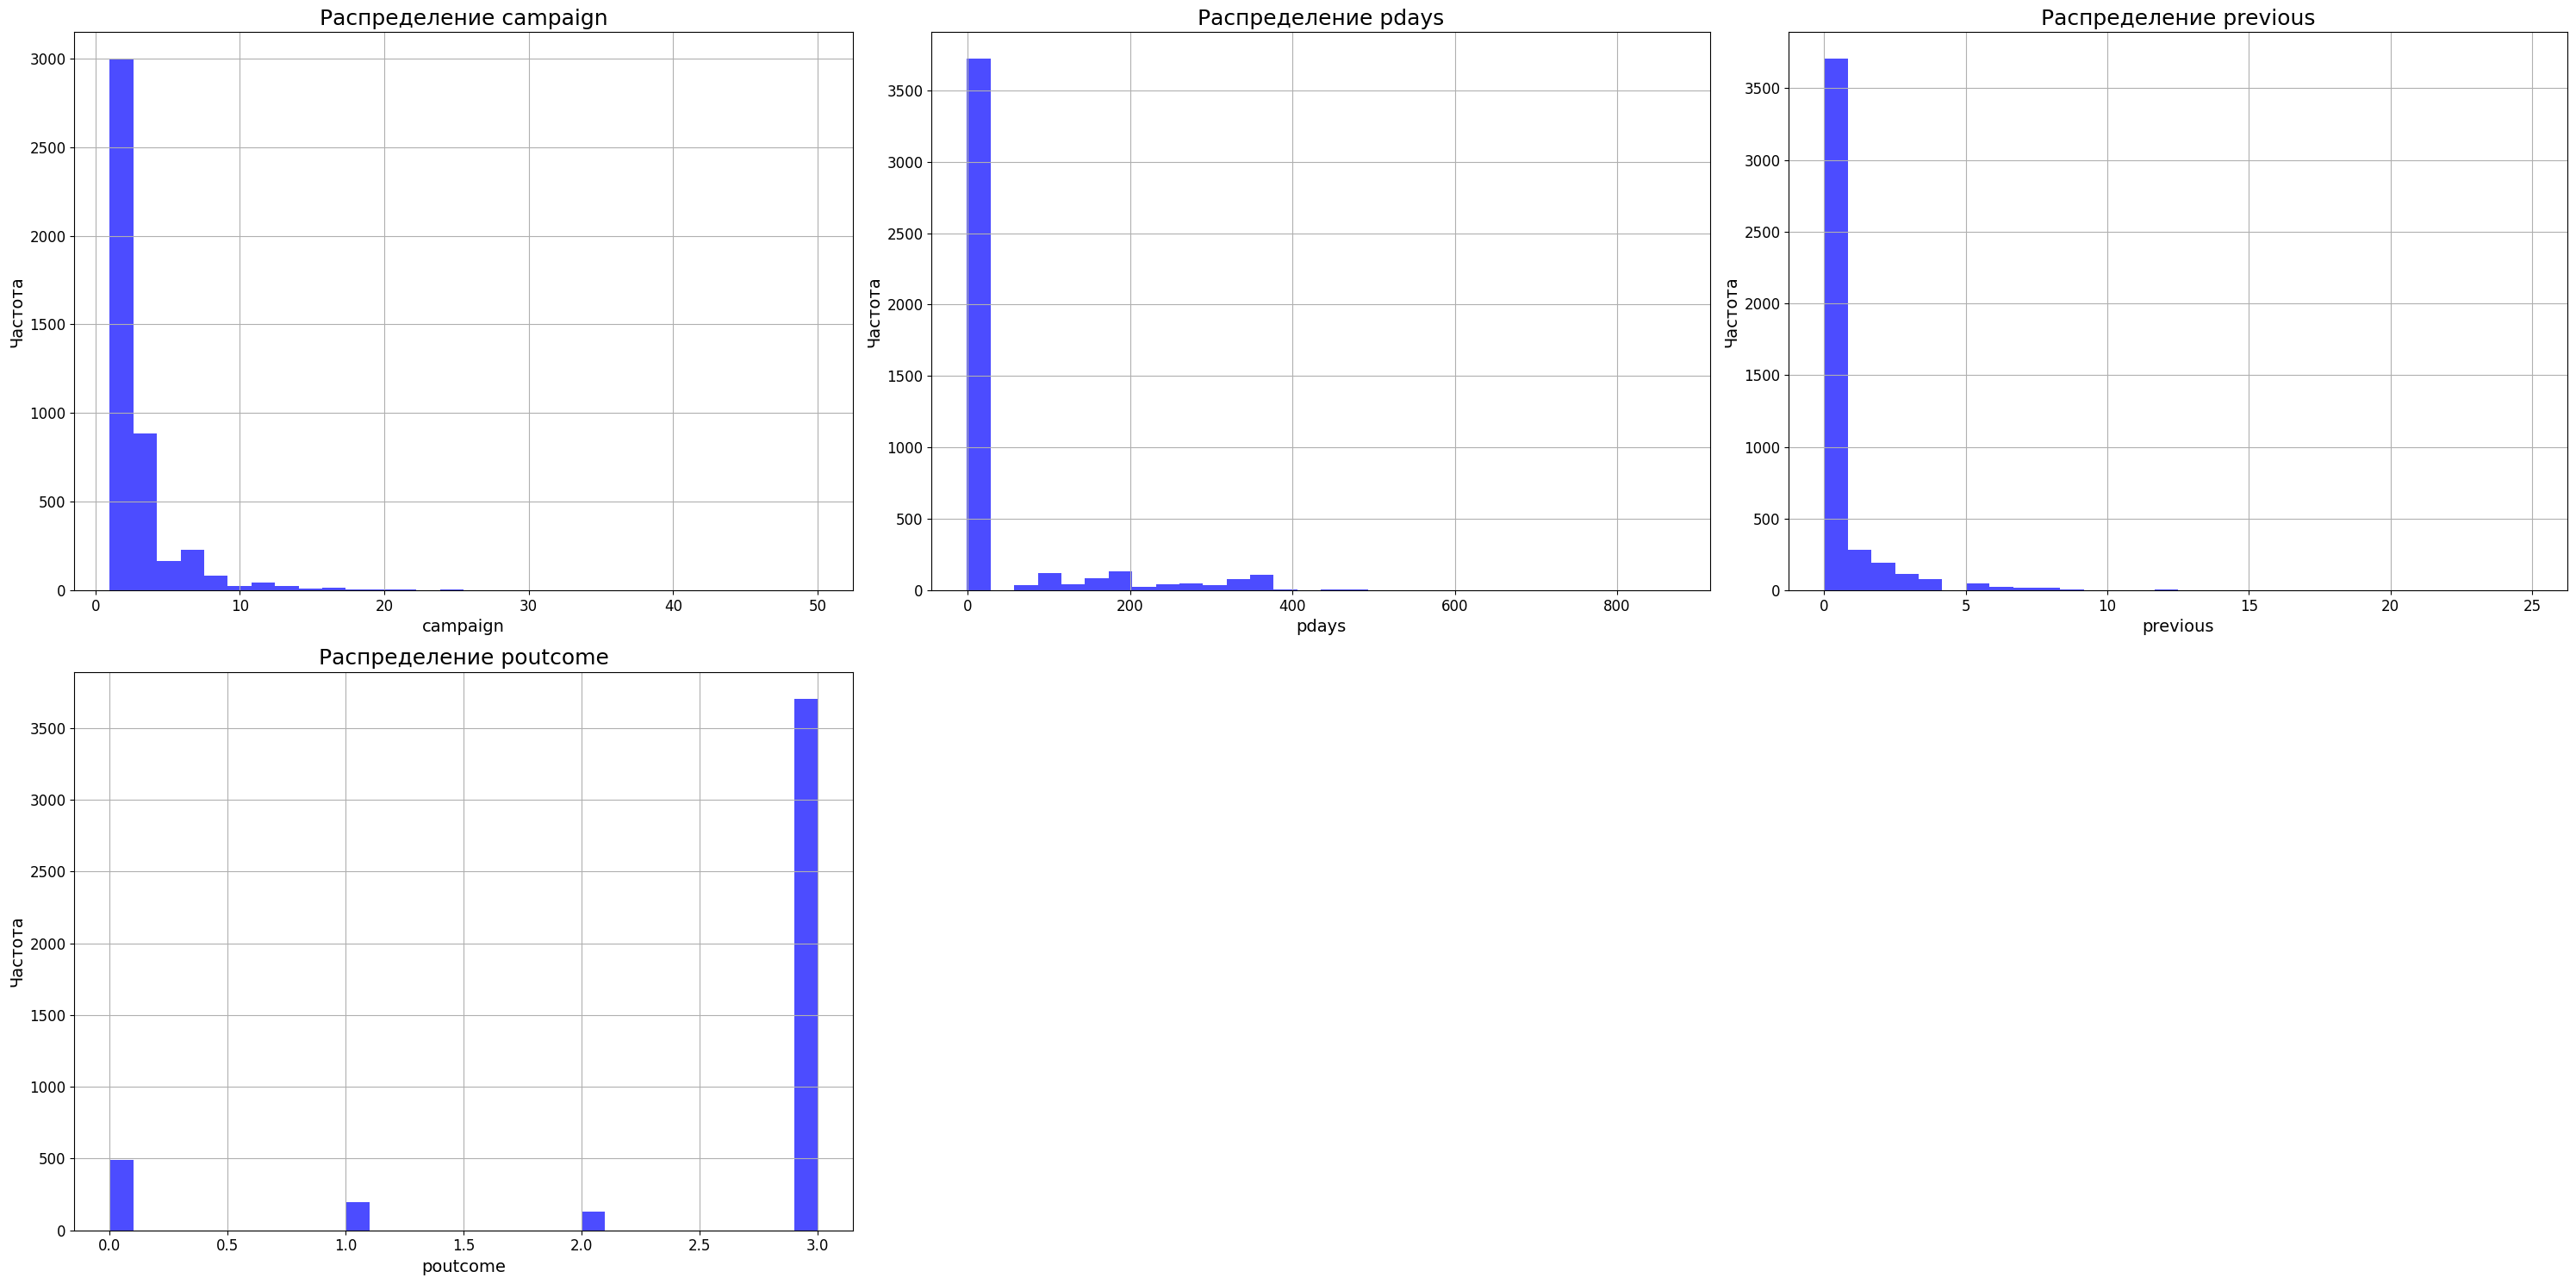

In [75]:
columns_list = df.columns.tolist()

plt.figure(figsize=(30, 15))
for i, feature in enumerate(columns_list[:6], 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=30, alpha=0.7, color='blue')
    plt.title(f'Распределение {feature}', fontsize=18)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(30, 15))
for i, feature in enumerate(columns_list[6:12], 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=30, alpha=0.7, color='blue')
    plt.title(f'Распределение {feature}', fontsize=18)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(30, 15))
for i, feature in enumerate(columns_list[12:16], 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=30, alpha=0.7, color='blue')
    plt.title(f'Распределение {feature}', fontsize=18)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Сделаем Boxplot:

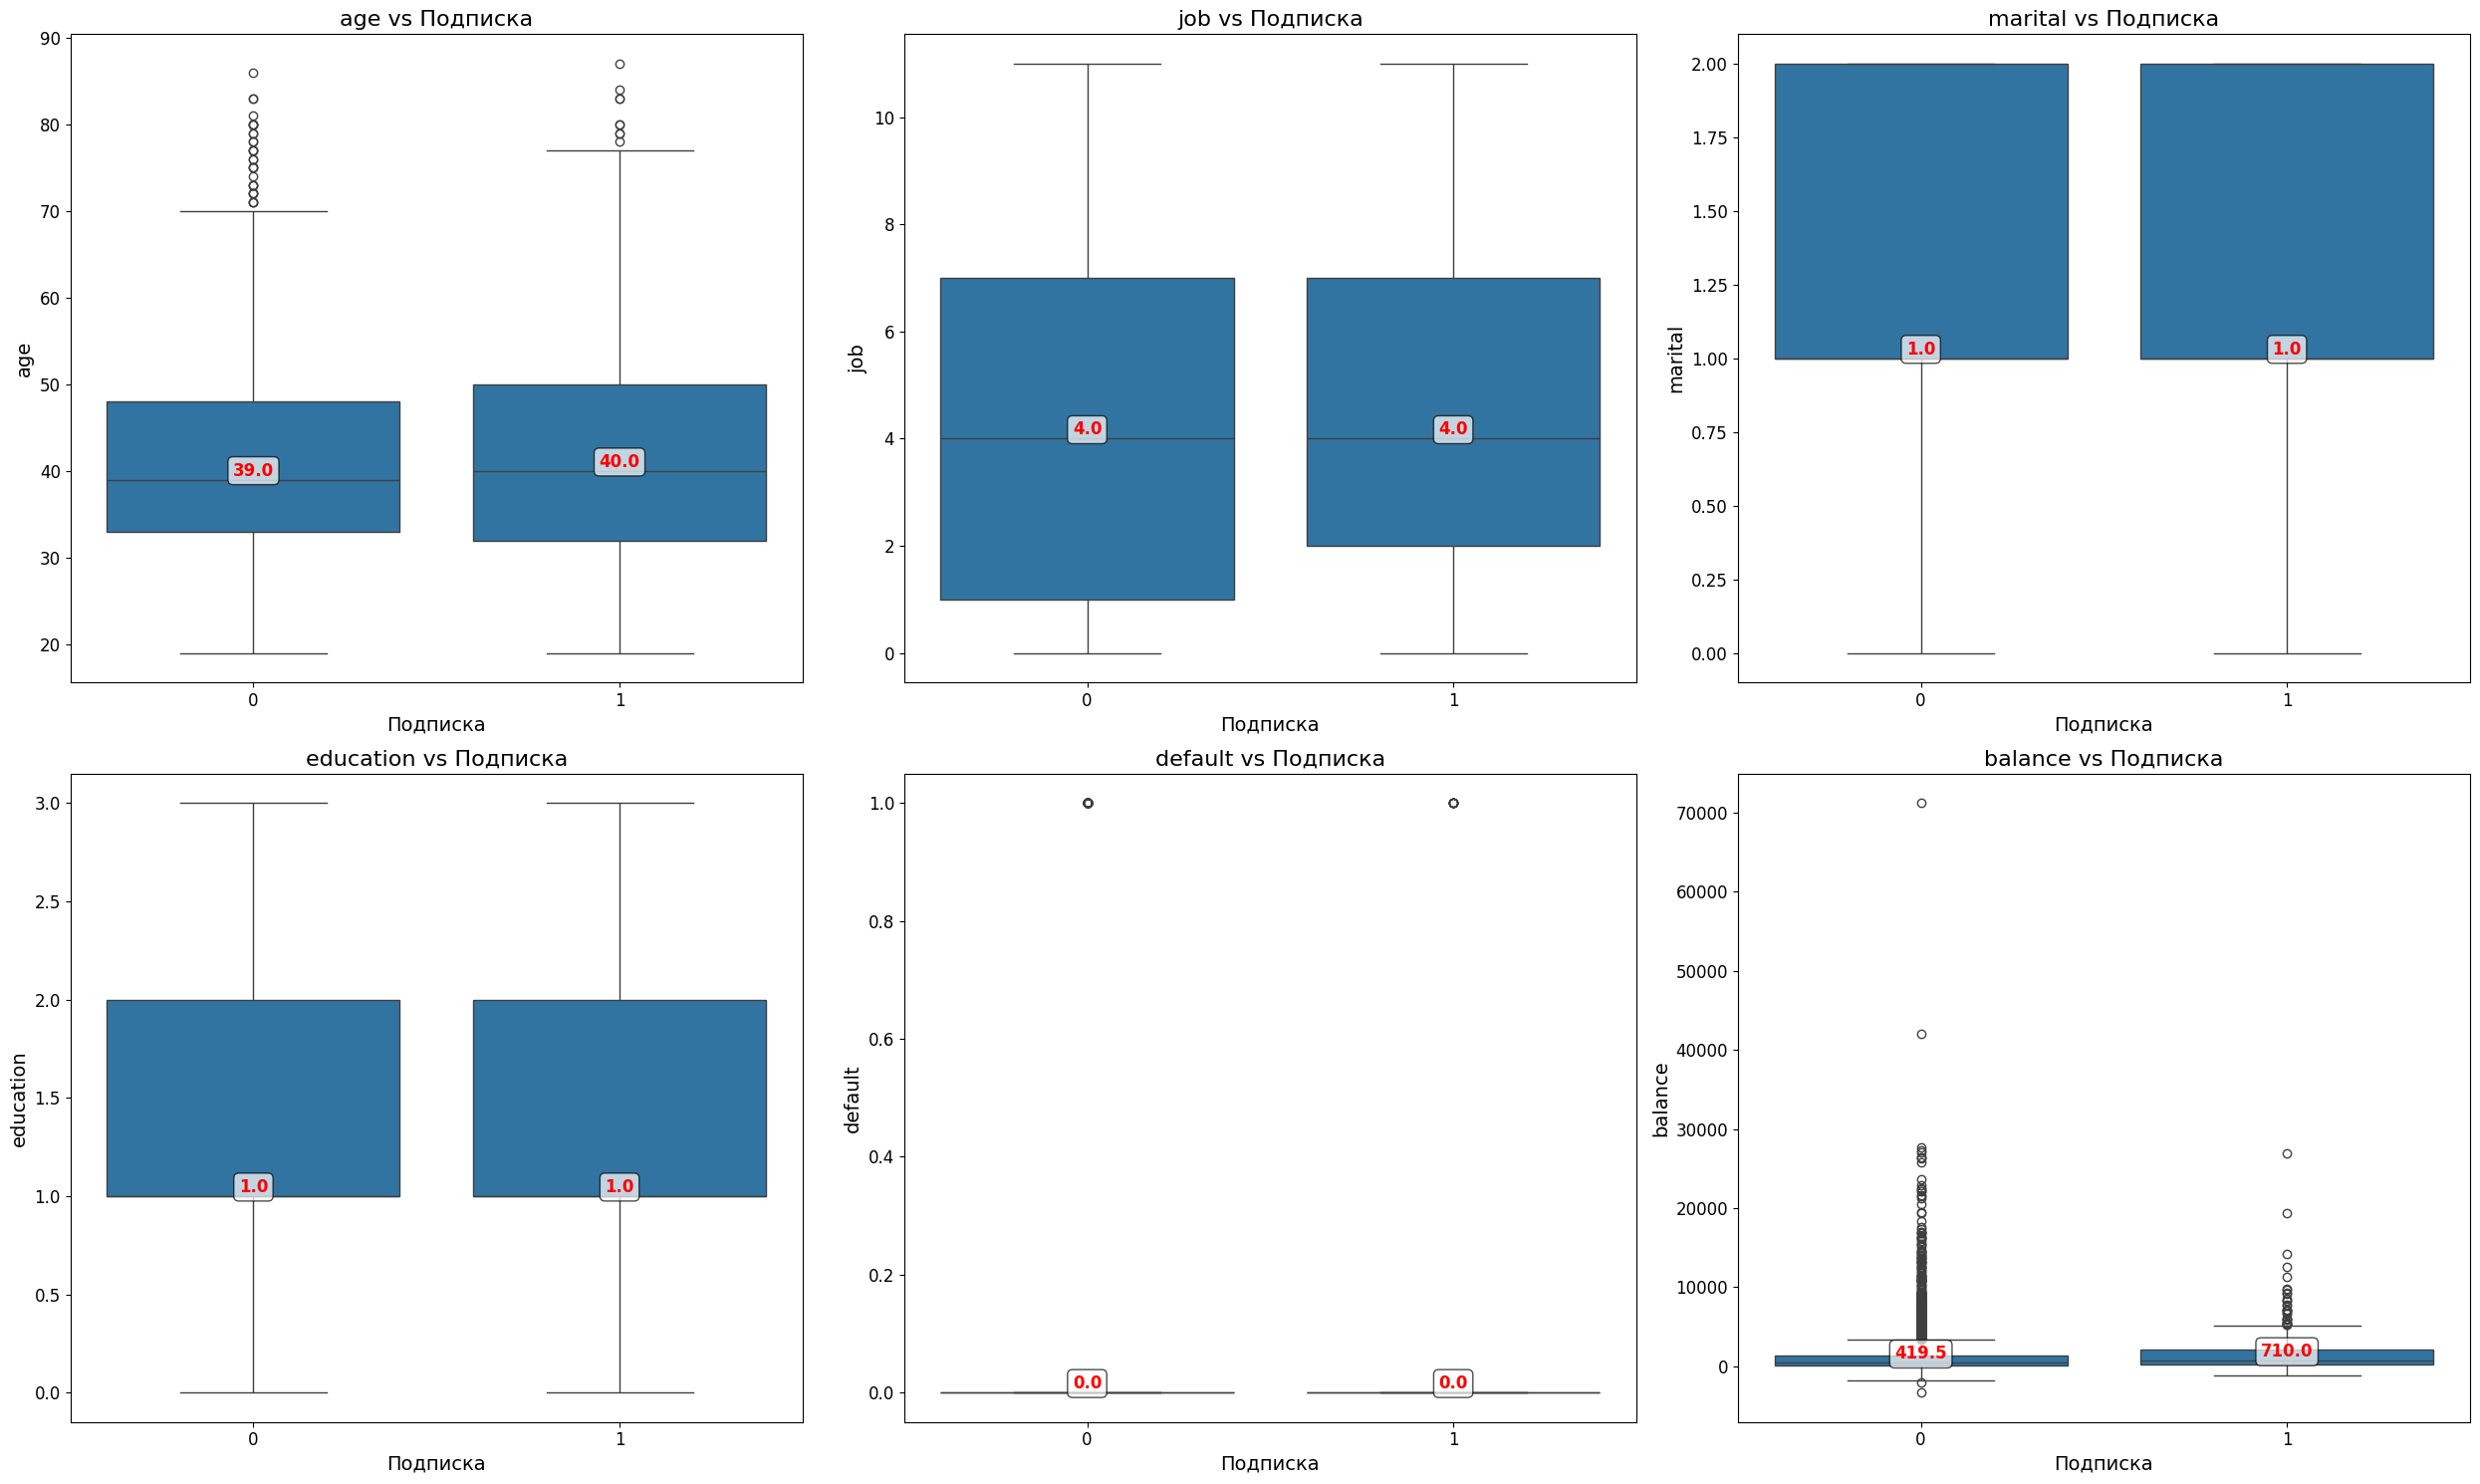

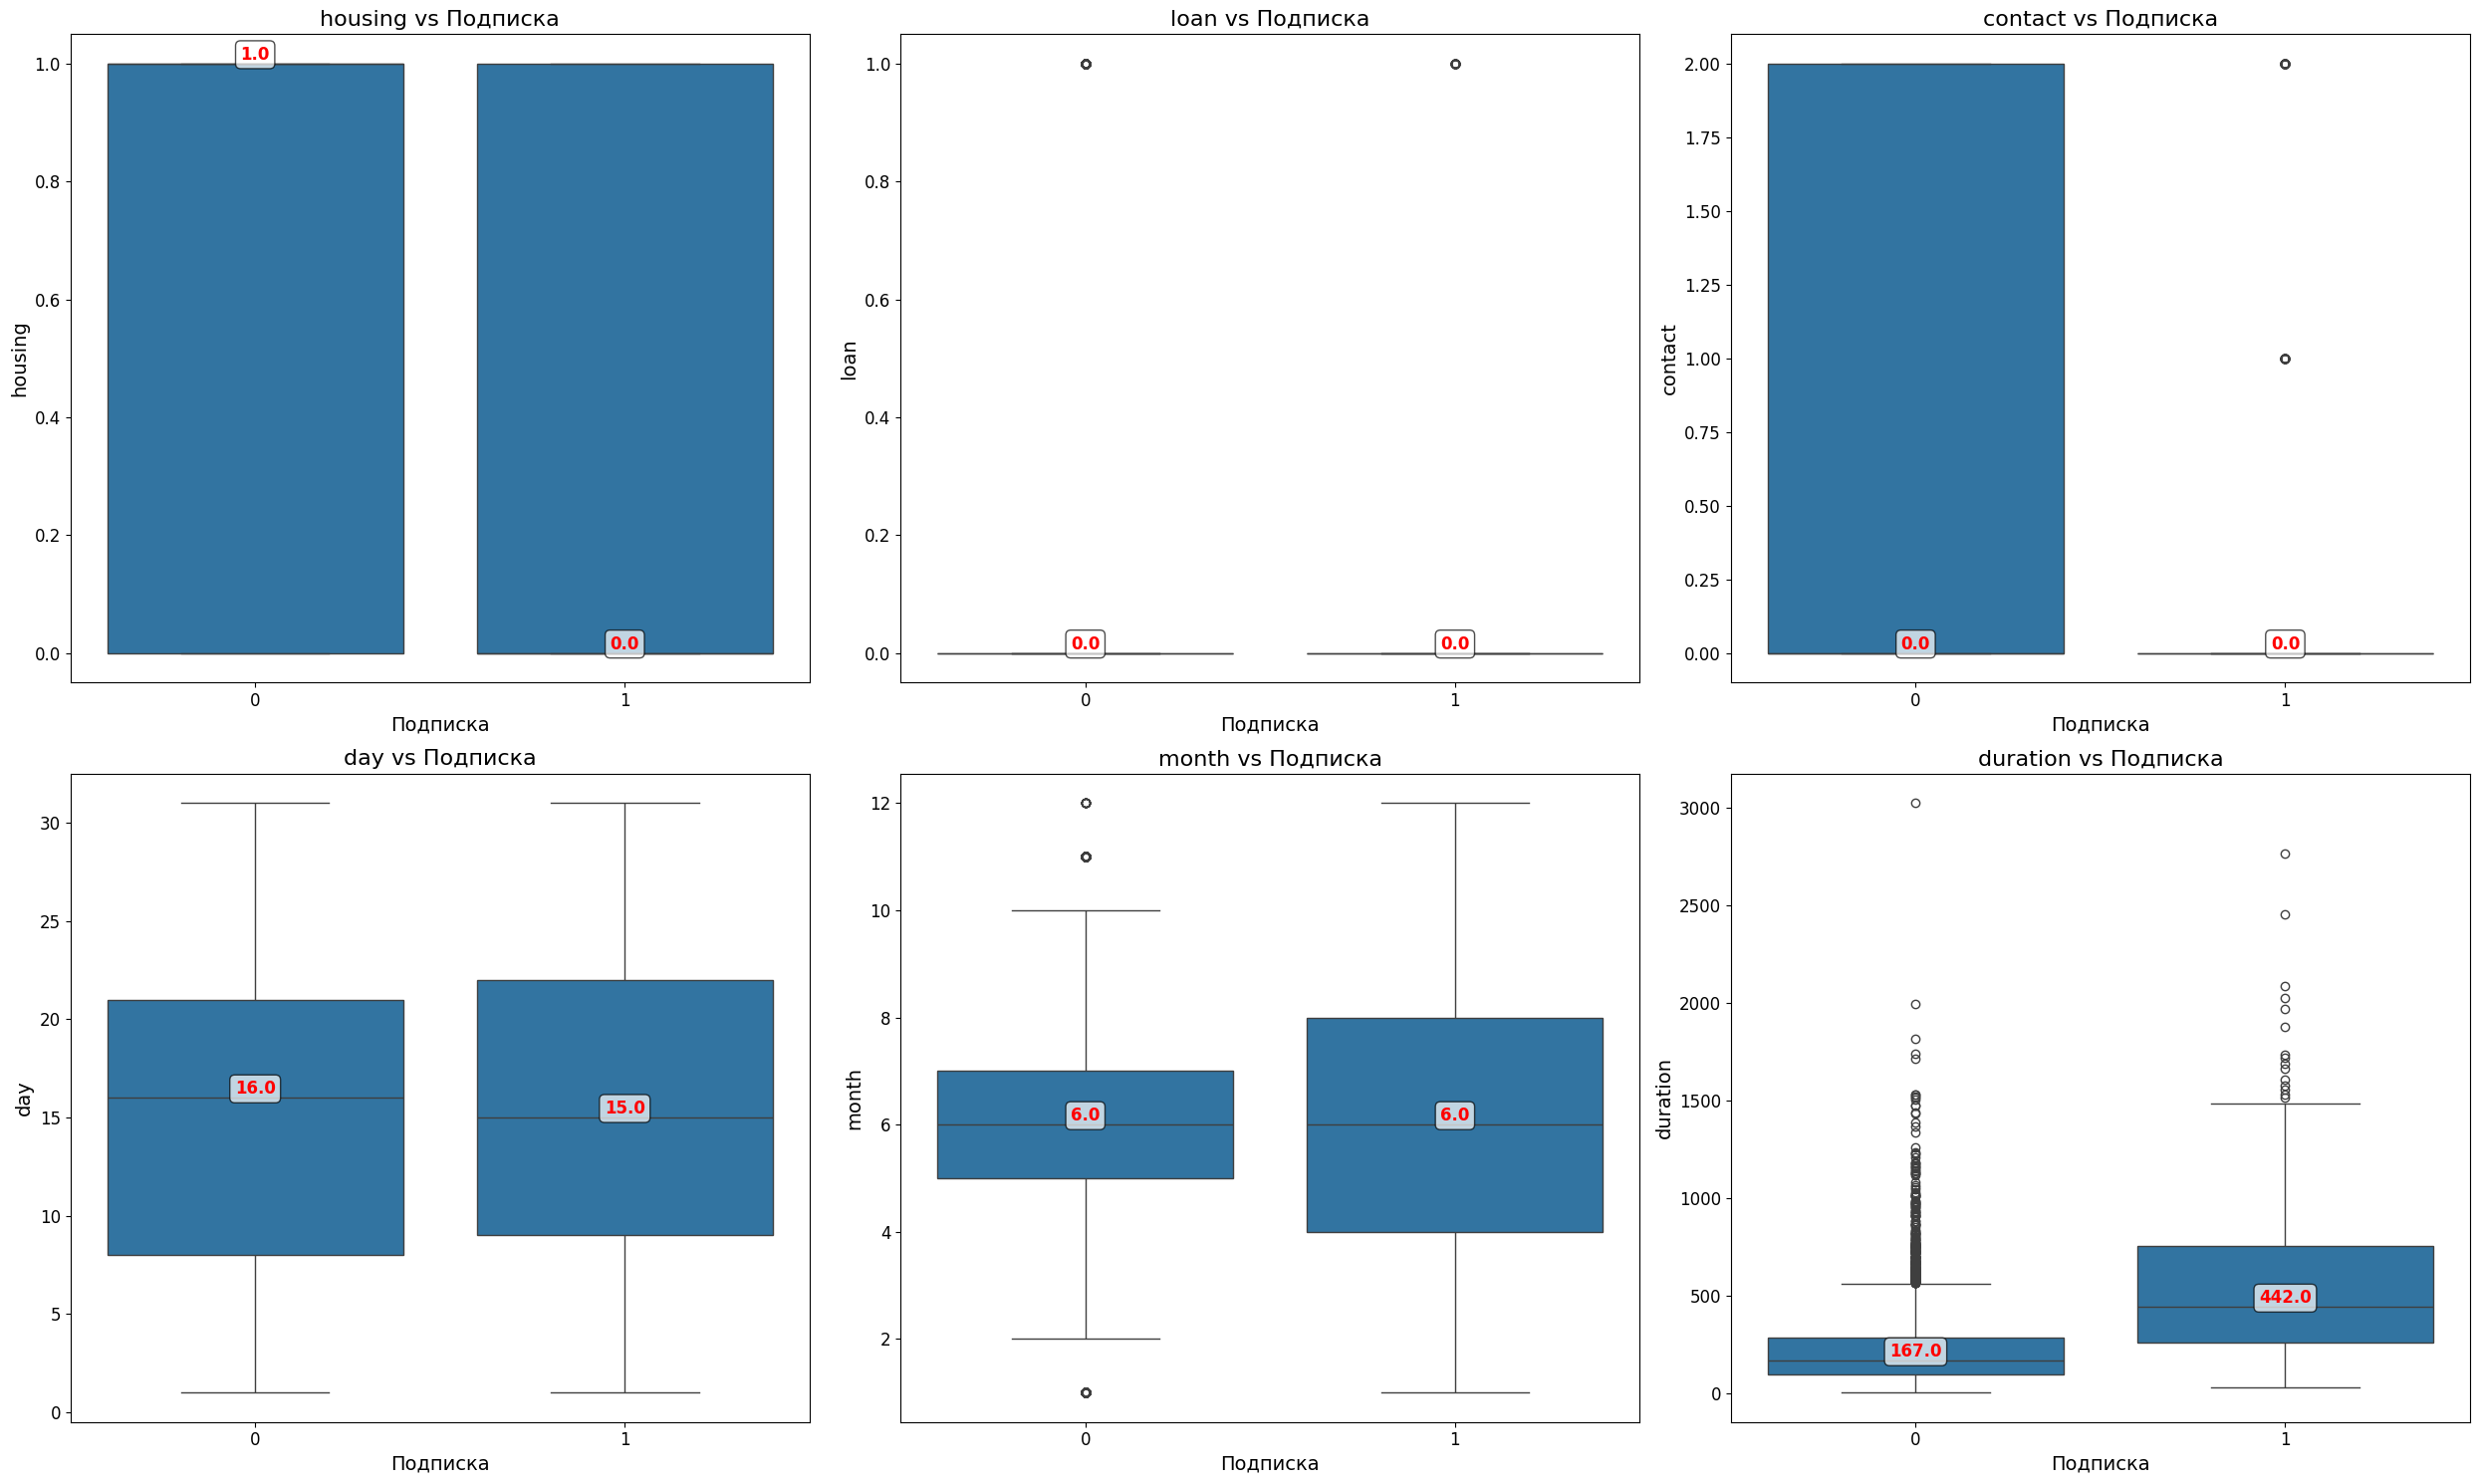

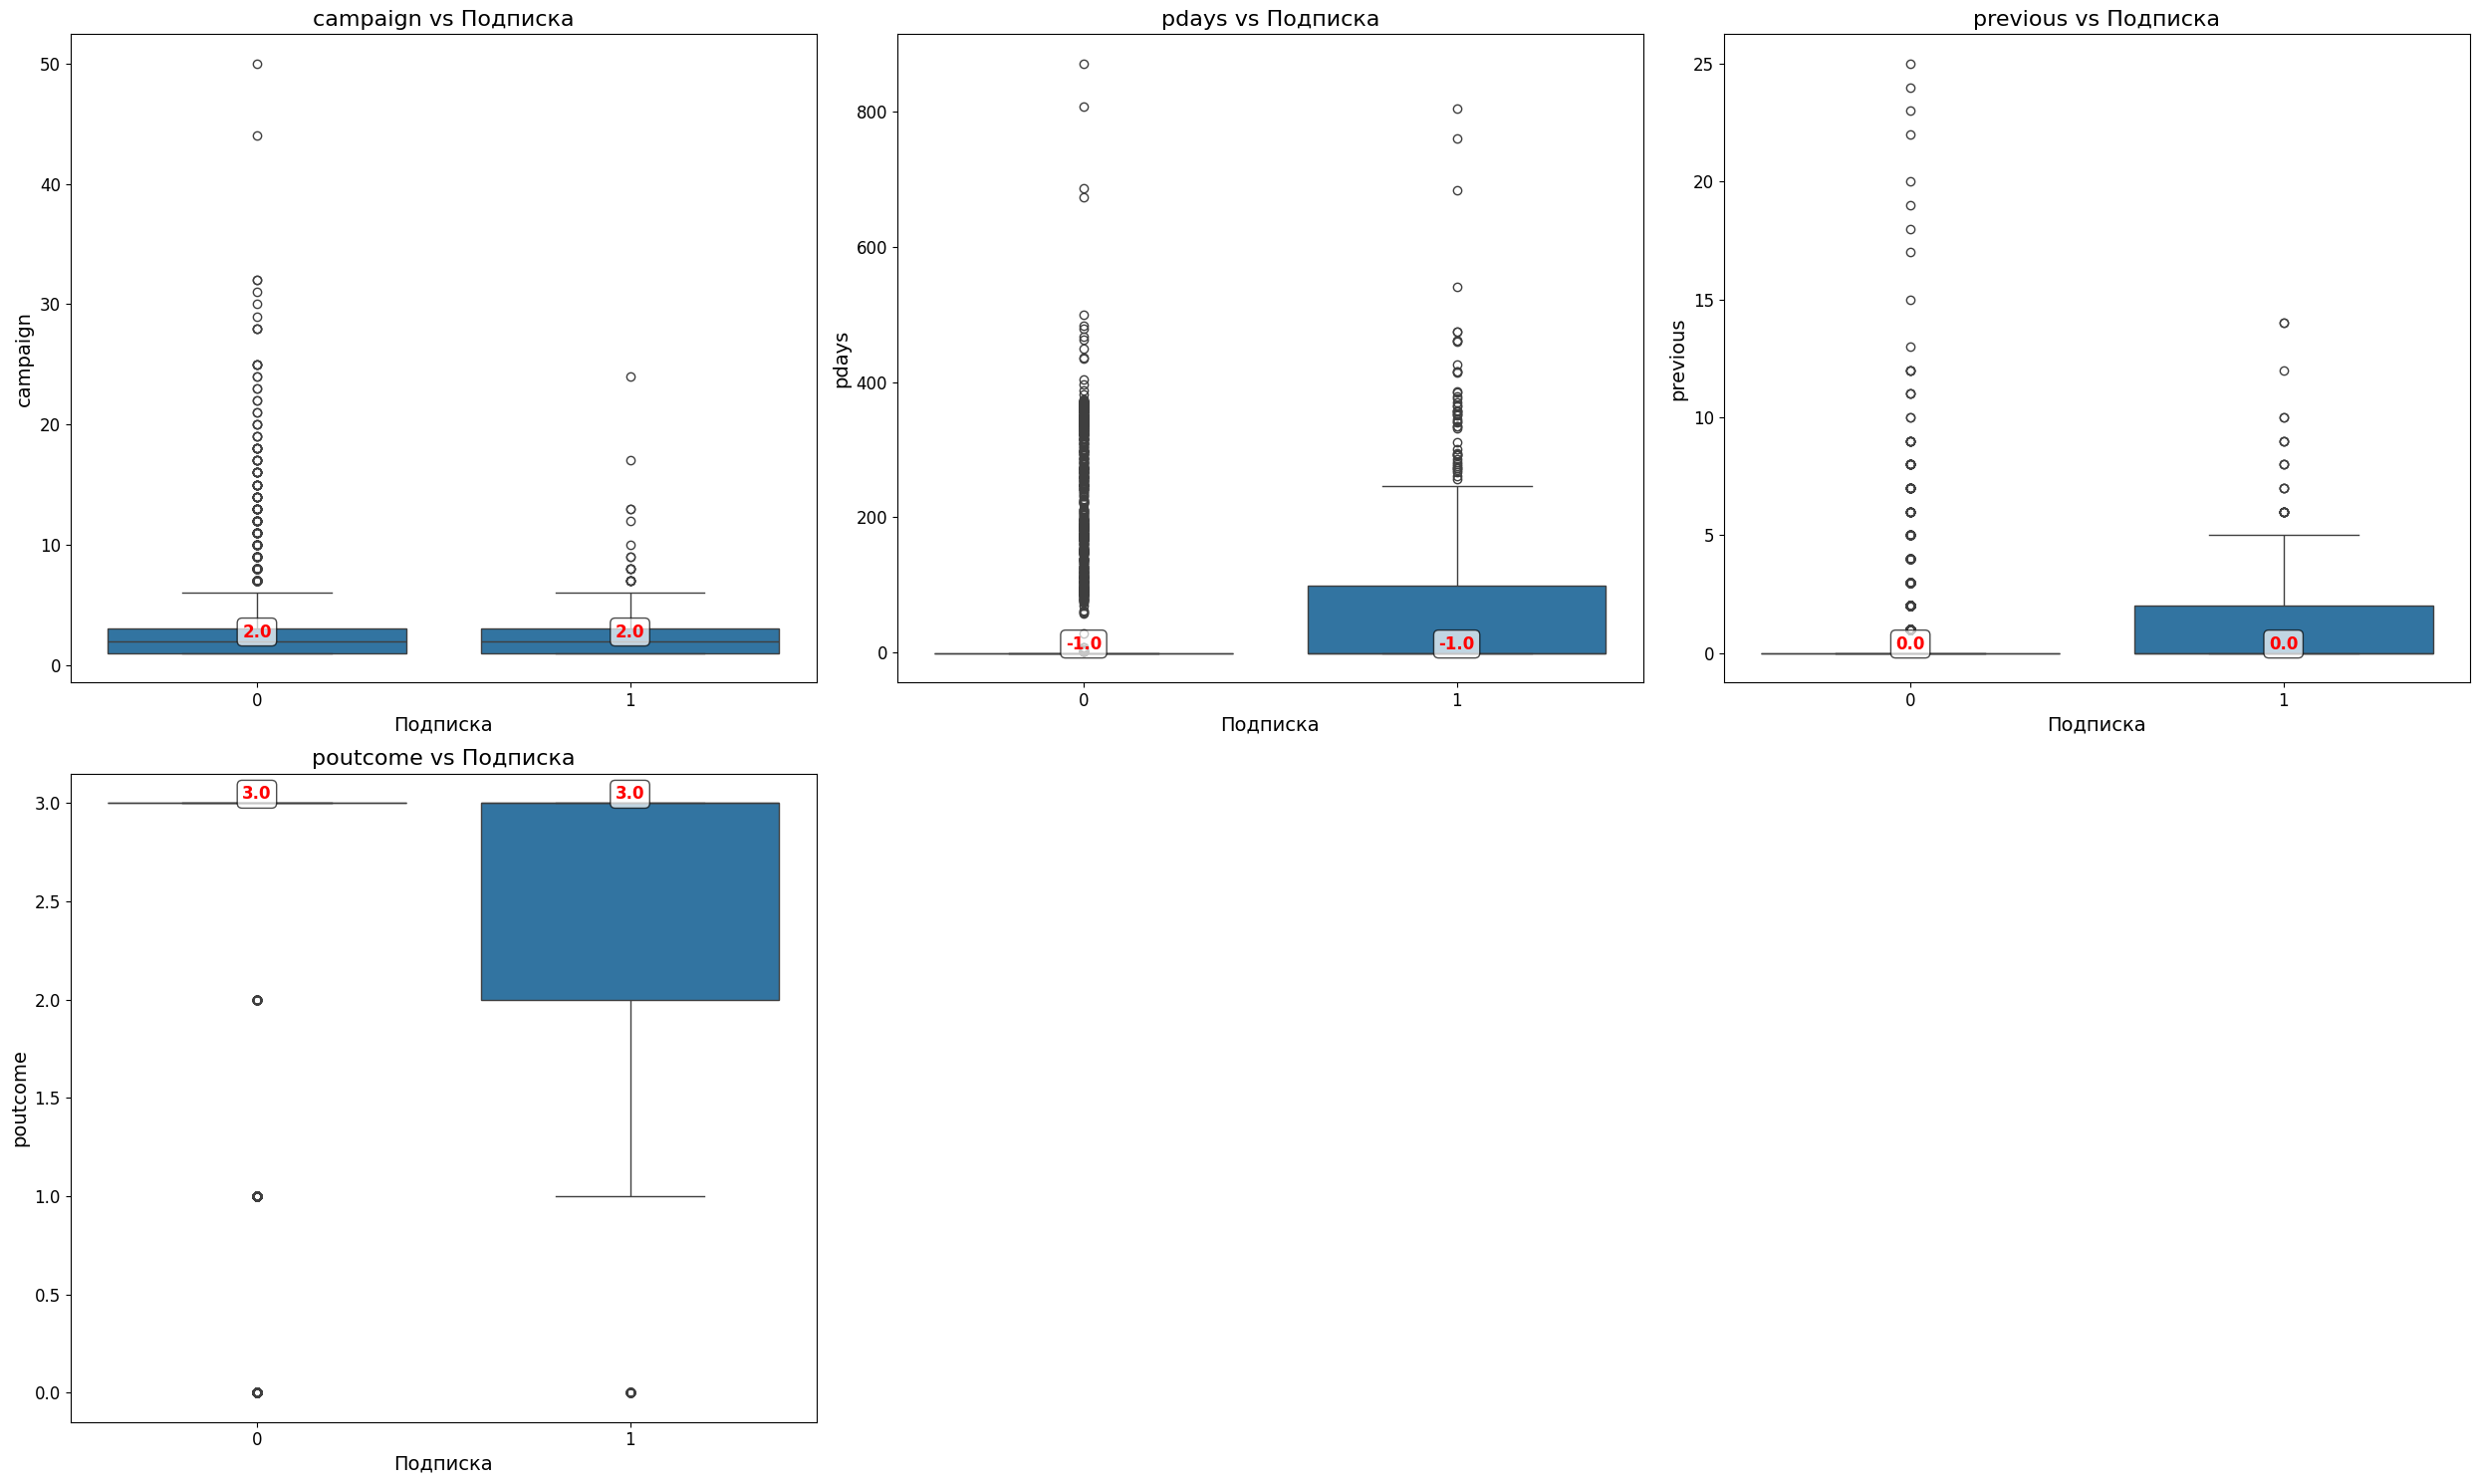

In [76]:
import seaborn as sns


plt.figure(figsize=(25, 15), dpi=100)
for i, (feature, title) in enumerate(zip(columns_list[:6], columns_list[:6]), 1):
    plt.subplot(2, 3, i)
    ax = sns.boxplot(data=df, x='y', y=feature)
    plt.title(f'{title} vs Подписка', fontsize=16)
    plt.xlabel('Подписка', fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    medians = df.groupby('y')[feature].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median:.1f}',
                ha='center', va='bottom', fontweight='bold',
                color='red', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 15), dpi=100)
for i, (feature, title) in enumerate(zip(columns_list[6:12], columns_list[6:12]), 1):
    plt.subplot(2, 3, i)
    ax = sns.boxplot(data=df, x='y', y=feature)
    plt.title(f'{title} vs Подписка', fontsize=16)
    plt.xlabel('Подписка', fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    medians = df.groupby('y')[feature].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median:.1f}',
                ha='center', va='bottom', fontweight='bold',
                color='red', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 15), dpi=100)
for i, (feature, title) in enumerate(zip(columns_list[12:16], columns_list[12:16]), 1):
    plt.subplot(2, 3, i)
    ax = sns.boxplot(data=df, x='y', y=feature)
    plt.title(f'{title} vs Подписка', fontsize=16)
    plt.xlabel('Подписка', fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    medians = df.groupby('y')[feature].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median:.1f}',
                ha='center', va='bottom', fontweight='bold',
                color='red', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

### Выводы:
- Длительность звонка существенно влияет на то, подписался ли клиент на депозит или нет, обычно длительность звонка, того, кто подписался примерно 442 секунды, что больше 10 минут.
- Впринципе от возраста не зависит то, подписался ли клиент или нет.
- От баланса тоже существенно зависит то, подписался или нет. Средний баланс того, кто подписался почти в два раза больше, тем те, кто отказался.
- Видим, что campaign ничего впринципе не значит, оно не сильно влияет на это.
- Наблюдаем, что от previous тоже многое зависит, хотя среднее значение и там и там одинаково, но если клиент до этого принимал участие в других кампаниях, то шансы того, что он подпишется больше.
- видим еще одну закономерность, обычно подписываются к депозиту те, кто не имеет ипотек(housing).
- Остальные же признаки не особо выделяются.

### Теперь перейдем к подбору гиперпараметров
- буду использовать GridSearchCV для поиска лучших параметров для каждого метода
- буду использовать StratifiedKFold для кросс - валидации
- буду использовать StandardScaler для масштабирования
- буду использовать такие методы классификации: RandomForestClassifier, SVC, LogisticRegression, KNeighborsClassifier

разделяем данные

In [77]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:16].tolist()]
Y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

Теперь создадим словарь с метриками и их гиперпараметрами, произведем масштабирование, кросс - валидацию и SMOTE.

In [78]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE


# Scaling the data once
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

models_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },

    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },

    'K-Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

results = {}
best_models = {}

for model_name, config in models_config.items():

    #Grid_search
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )


    grid_search.fit(X_train_smote, y_train_smote)

    best_models[model_name] = grid_search.best_estimator_

    y_pred = grid_search.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'test_precision': precision,
        'test_recall': recall,
        'predictions': y_pred
    }

#### Теперь же выведем confusion matrix для лучших моделей

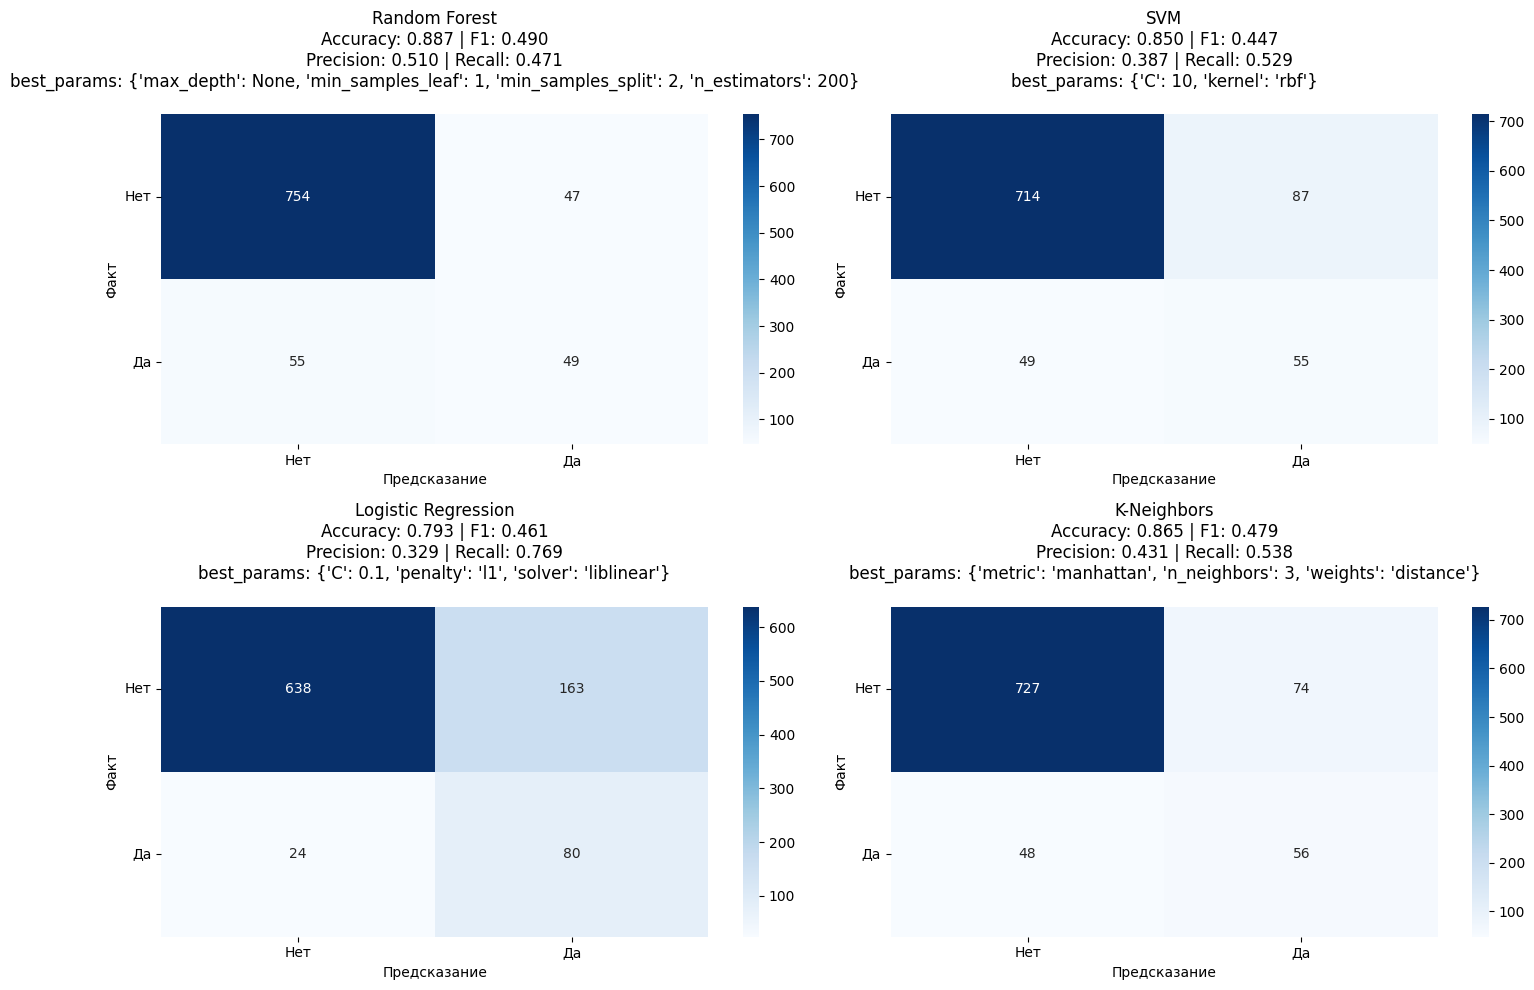

In [79]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 10))

for i, model_name in enumerate(best_models.keys(), 1):
    plt.subplot(2, 2, i)

    y_pred = results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    accuracy = results[model_name]['test_accuracy']
    f1 = results[model_name]['test_f1']
    recall = results[model_name]['test_recall']
    precision = results[model_name]['test_precision']
    best_params = results[model_name]['best_params']

    plt.title(f'{model_name}\nAccuracy: {accuracy:.3f} | F1: {f1:.3f}\nPrecision: {precision:.3f} | Recall: {recall:.3f}\nbest_params: {best_params}', pad=20)
    plt.xlabel('Предсказание')
    plt.ylabel('Факт')
    plt.xticks([0.5, 1.5], ['Нет', 'Да'])
    plt.yticks([0.5, 1.5], ['Нет', 'Да'], rotation=0)

plt.tight_layout()
plt.show()

#### Вывод
- Random Forest - Accuracy 0.887 - лучшая общая точность. F1-score 0.490 - самый лучший среди моделей. Сильные стороны: Находит 754 из 801 реальных отказов. Слабые стороны: Находит всего лишь 49 реальных депозитов
- SVM - Оптимальный для банка. Accuracy 0.850 - довольно неплохо, F1-score 0.447 - тоже очень не очень. Сильные стороны: нет. Слабые стороны: 87 ложных вызова - высокие затраты на маркетинг. Просто довольно - таки средний результат. Худший для нашей задачи.
- Logistic Regression -  лучшая. Accuracy 0.793 - хорошая общая точность. F1-score 0.461 -  почти лучший показатель. Сильные стороны: находит 80 из 104 реальных депозитов. Это очень хороший результат. Слабые стороны: 163 ЛОЖНЫХ ВЫЗОВА - это очень много.
- K-Neighbors - Accuracy 0.865 - высокая за счет предсказания "нет" точность. F1-score 0.479 - средний результат, но модель получилась лучше, чем SVM, так как на 1 больше реальных депозитов и больше реальных "нет".

### Общий вывод
- для поиска клиентов для подписания депозитов лучше всего использовать Logistic Regression, так как нам важно количество клиентов, которые подписали депозит намного больше, чем ДАЖЕ 163 ложных вызова.